In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
LATENT_DIM = 64
NUM_GENERATORS = 3

In [29]:
# Using the entirre dataset to prevent the discriminator overpowering the generator

In [30]:
X_train, X_test, Y_train, Y_test = data.get_dataset_augmented()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")

In [31]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [32]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fD = models.LatentDescriminator().to(device) # Since we ony have two elements
model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fD = torch.optim.Adam(model_fD.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [33]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_discriminator = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_discriminator_ = 0
    
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fD.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fD(Z)
        m_S = model_fD(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_BCE(m_S,torch.ones(m_S.shape[0],1,device = device))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P) 

        
        loss_S = loss1 + loss2 + loss3
        loss_Ae = loss5
        
        loss_D = criterion_BCE(m,torch.ones(m.shape[0],1,device = device))
        loss_D.backward(retain_graph=True)

        loss_D = criterion_BCE(m_S,torch.zeros(m_S.shape[0],1,device = device))
        loss_D.backward(retain_graph=True)

        
        loss_S.backward(retain_graph=True)
        loss_Ae.backward()
        
        optimiser_fD.step()
        optimiser_symmetry.step() 
        optimiser_fd.step()
        optimiser_fe.step()        
        loss_S_closure_ += loss1.item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_discriminator_ += loss5.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_discriminator_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_discriminator.append(loss_discriminator_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_discriminator_)
    print("=====================")
    

100%|██████████| 1328/1328 [00:19<00:00, 67.09it/s]


EPOCH 0 complete
Symmetry Closure Loss  4.889610469879874
Symmetry Orthogonality Loss  0.057905128441683676
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.2451223144959939
Oracle loss 0.2451223144959939


100%|██████████| 1328/1328 [00:19<00:00, 67.48it/s]


EPOCH 1 complete
Symmetry Closure Loss  5.4532505516187255
Symmetry Orthogonality Loss  0.04418877715452473
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.03334617721132867
Oracle loss 0.03334617721132867


100%|██████████| 1328/1328 [00:19<00:00, 66.90it/s]


EPOCH 2 complete
Symmetry Closure Loss  5.533855485628886
Symmetry Orthogonality Loss  0.03221809927721968
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.012883494866006245
Oracle loss 0.012883494866006245


100%|██████████| 1328/1328 [00:19<00:00, 66.98it/s]


EPOCH 3 complete
Symmetry Closure Loss  5.5339240069130815
Symmetry Orthogonality Loss  0.033999419159603764
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024891457212643546
Oracle loss 0.0024891457212643546


100%|██████████| 1328/1328 [00:19<00:00, 66.59it/s]


EPOCH 4 complete
Symmetry Closure Loss  5.537647507995008
Symmetry Orthogonality Loss  0.03498948309065617
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005073224934303982
Oracle loss 0.005073224934303982


100%|██████████| 1328/1328 [00:19<00:00, 67.55it/s]


EPOCH 5 complete
Symmetry Closure Loss  5.541836467493011
Symmetry Orthogonality Loss  0.03296018193661045
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001974080418298706
Oracle loss 0.001974080418298706


100%|██████████| 1328/1328 [00:19<00:00, 67.52it/s]


EPOCH 6 complete
Symmetry Closure Loss  5.543231058910669
Symmetry Orthogonality Loss  0.031947313227230704
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002037289706703336
Oracle loss 0.002037289706703336


100%|██████████| 1328/1328 [00:19<00:00, 66.51it/s]


EPOCH 7 complete
Symmetry Closure Loss  5.5441978056746795
Symmetry Orthogonality Loss  0.031266623173829125
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010588574752973619
Oracle loss 0.0010588574752973619


 47%|████▋     | 625/1328 [00:09<00:11, 63.64it/s]


KeyboardInterrupt: 

In [34]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


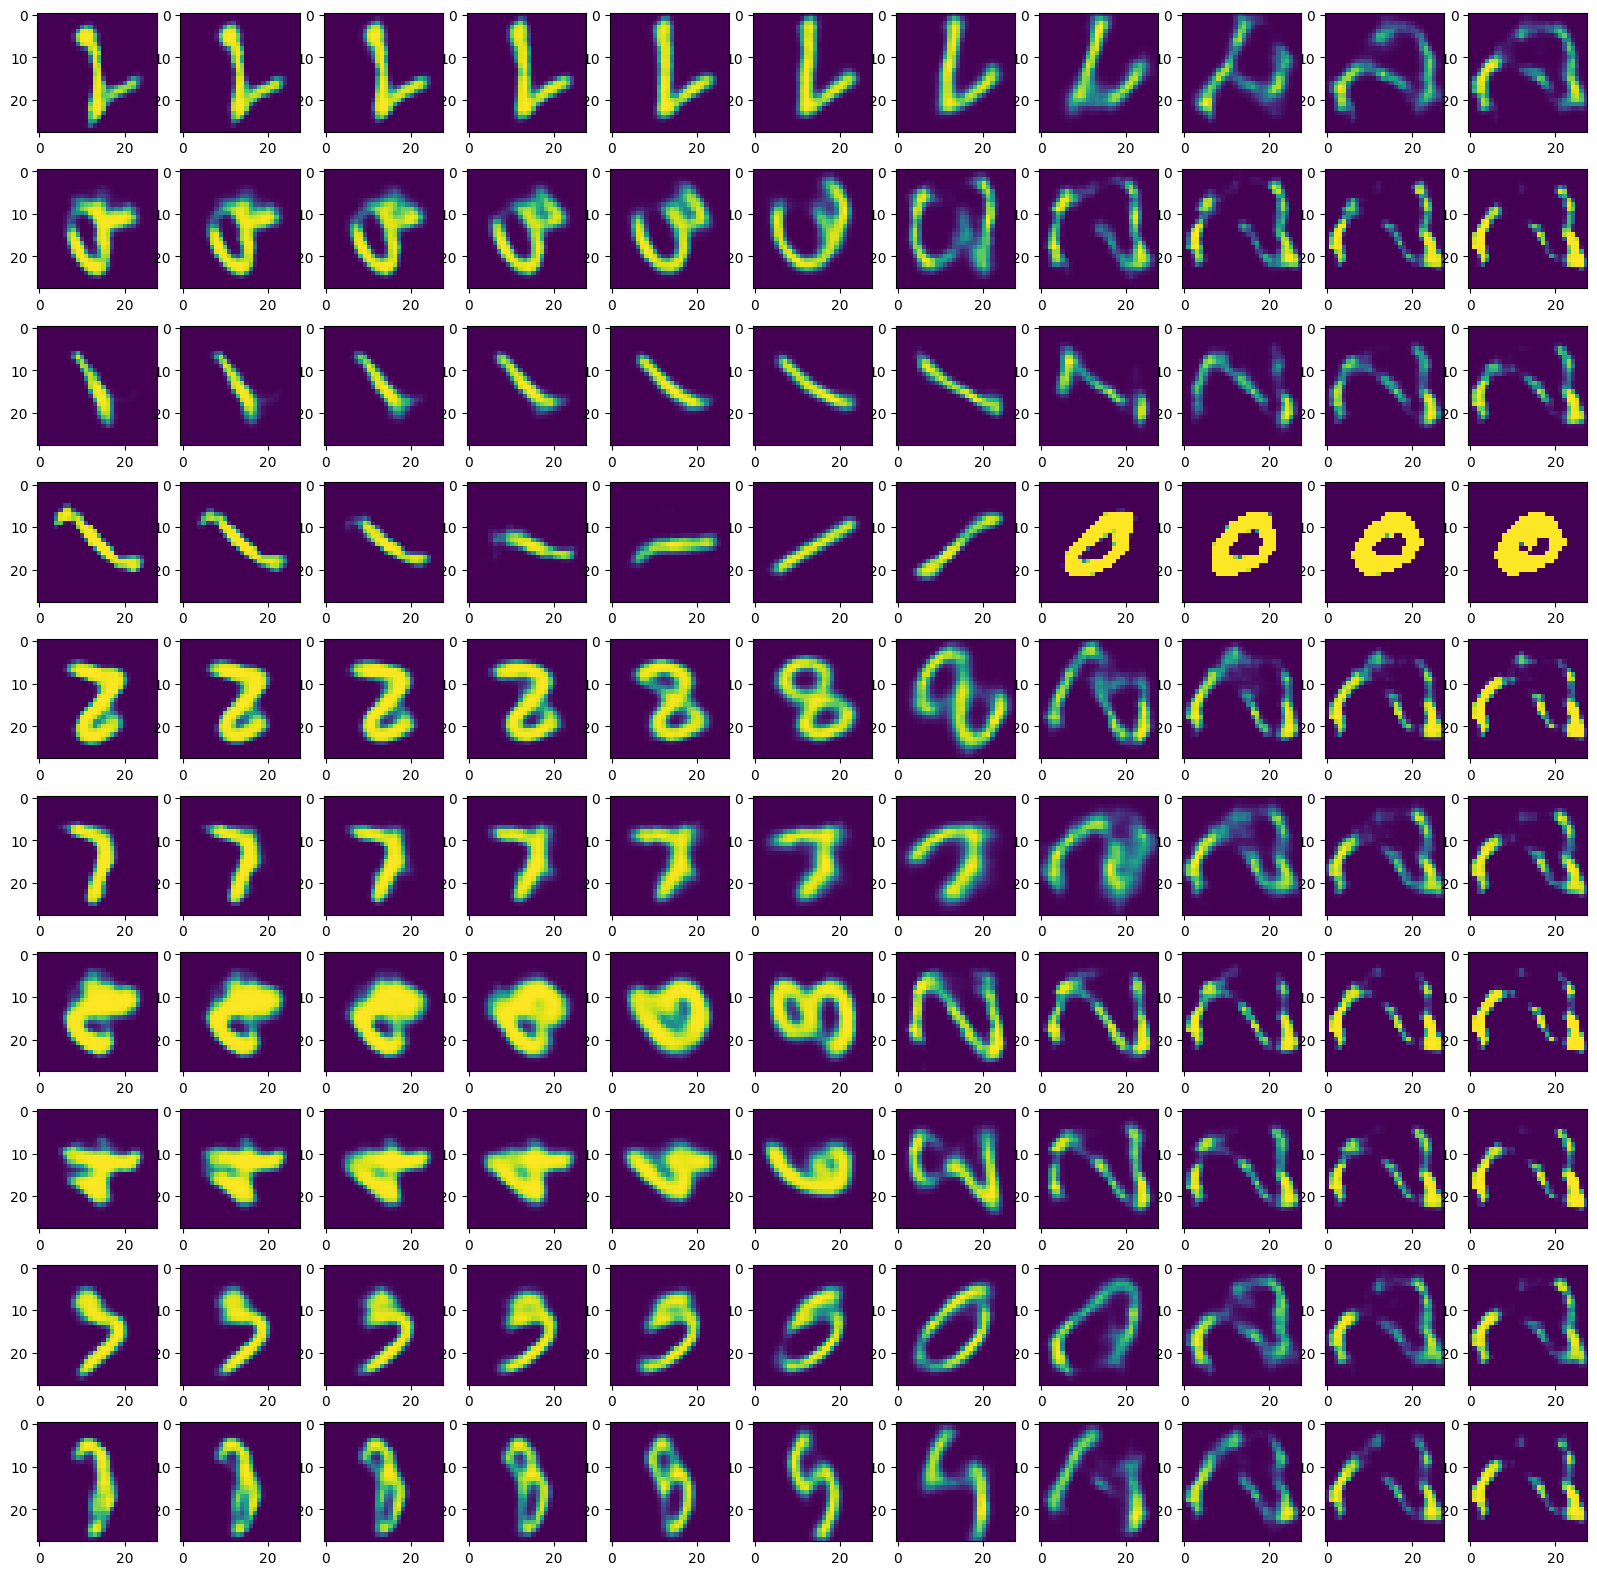

In [35]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

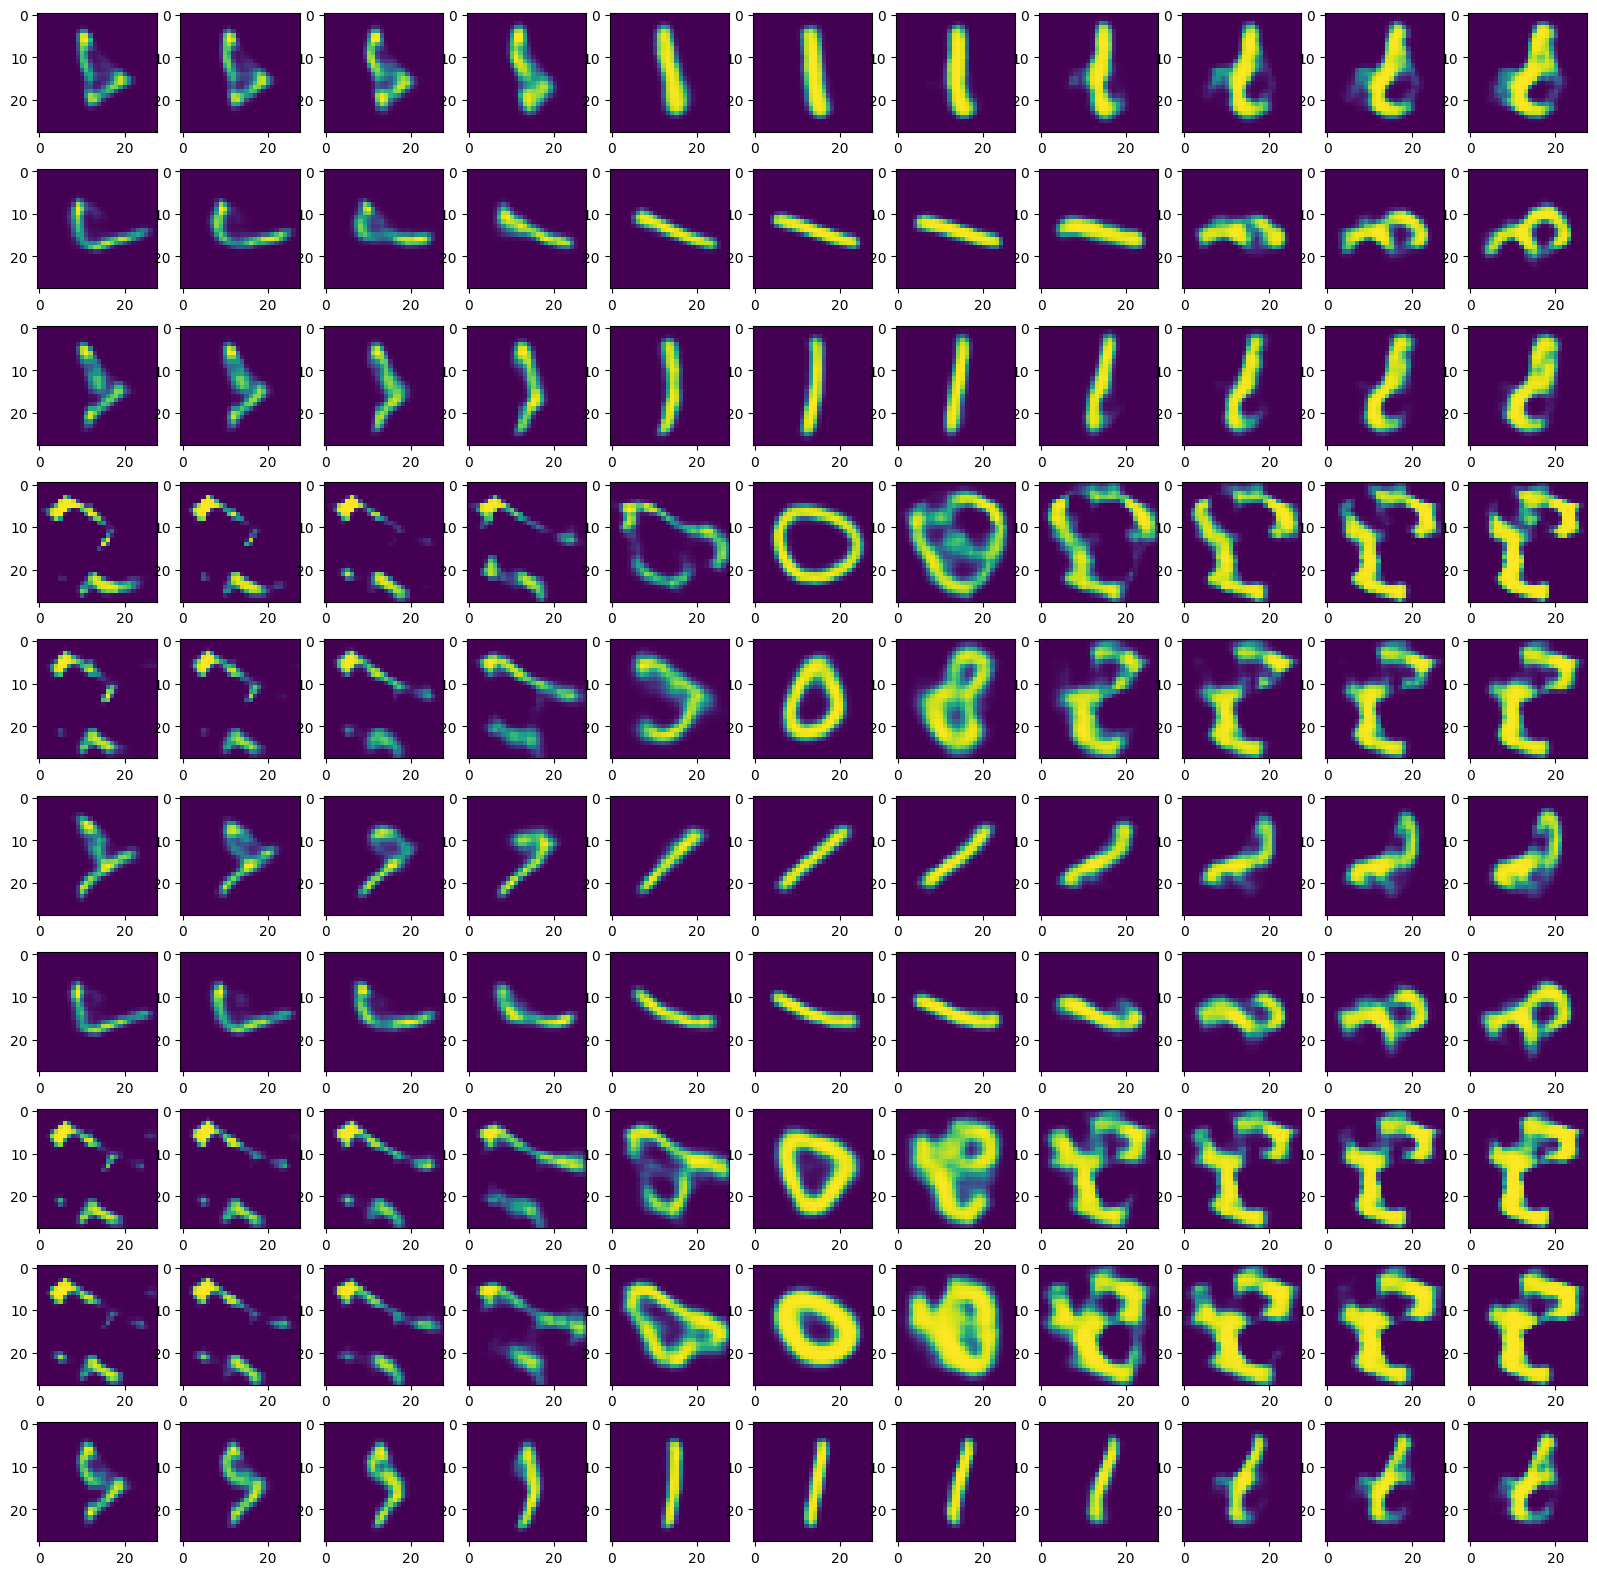

In [23]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

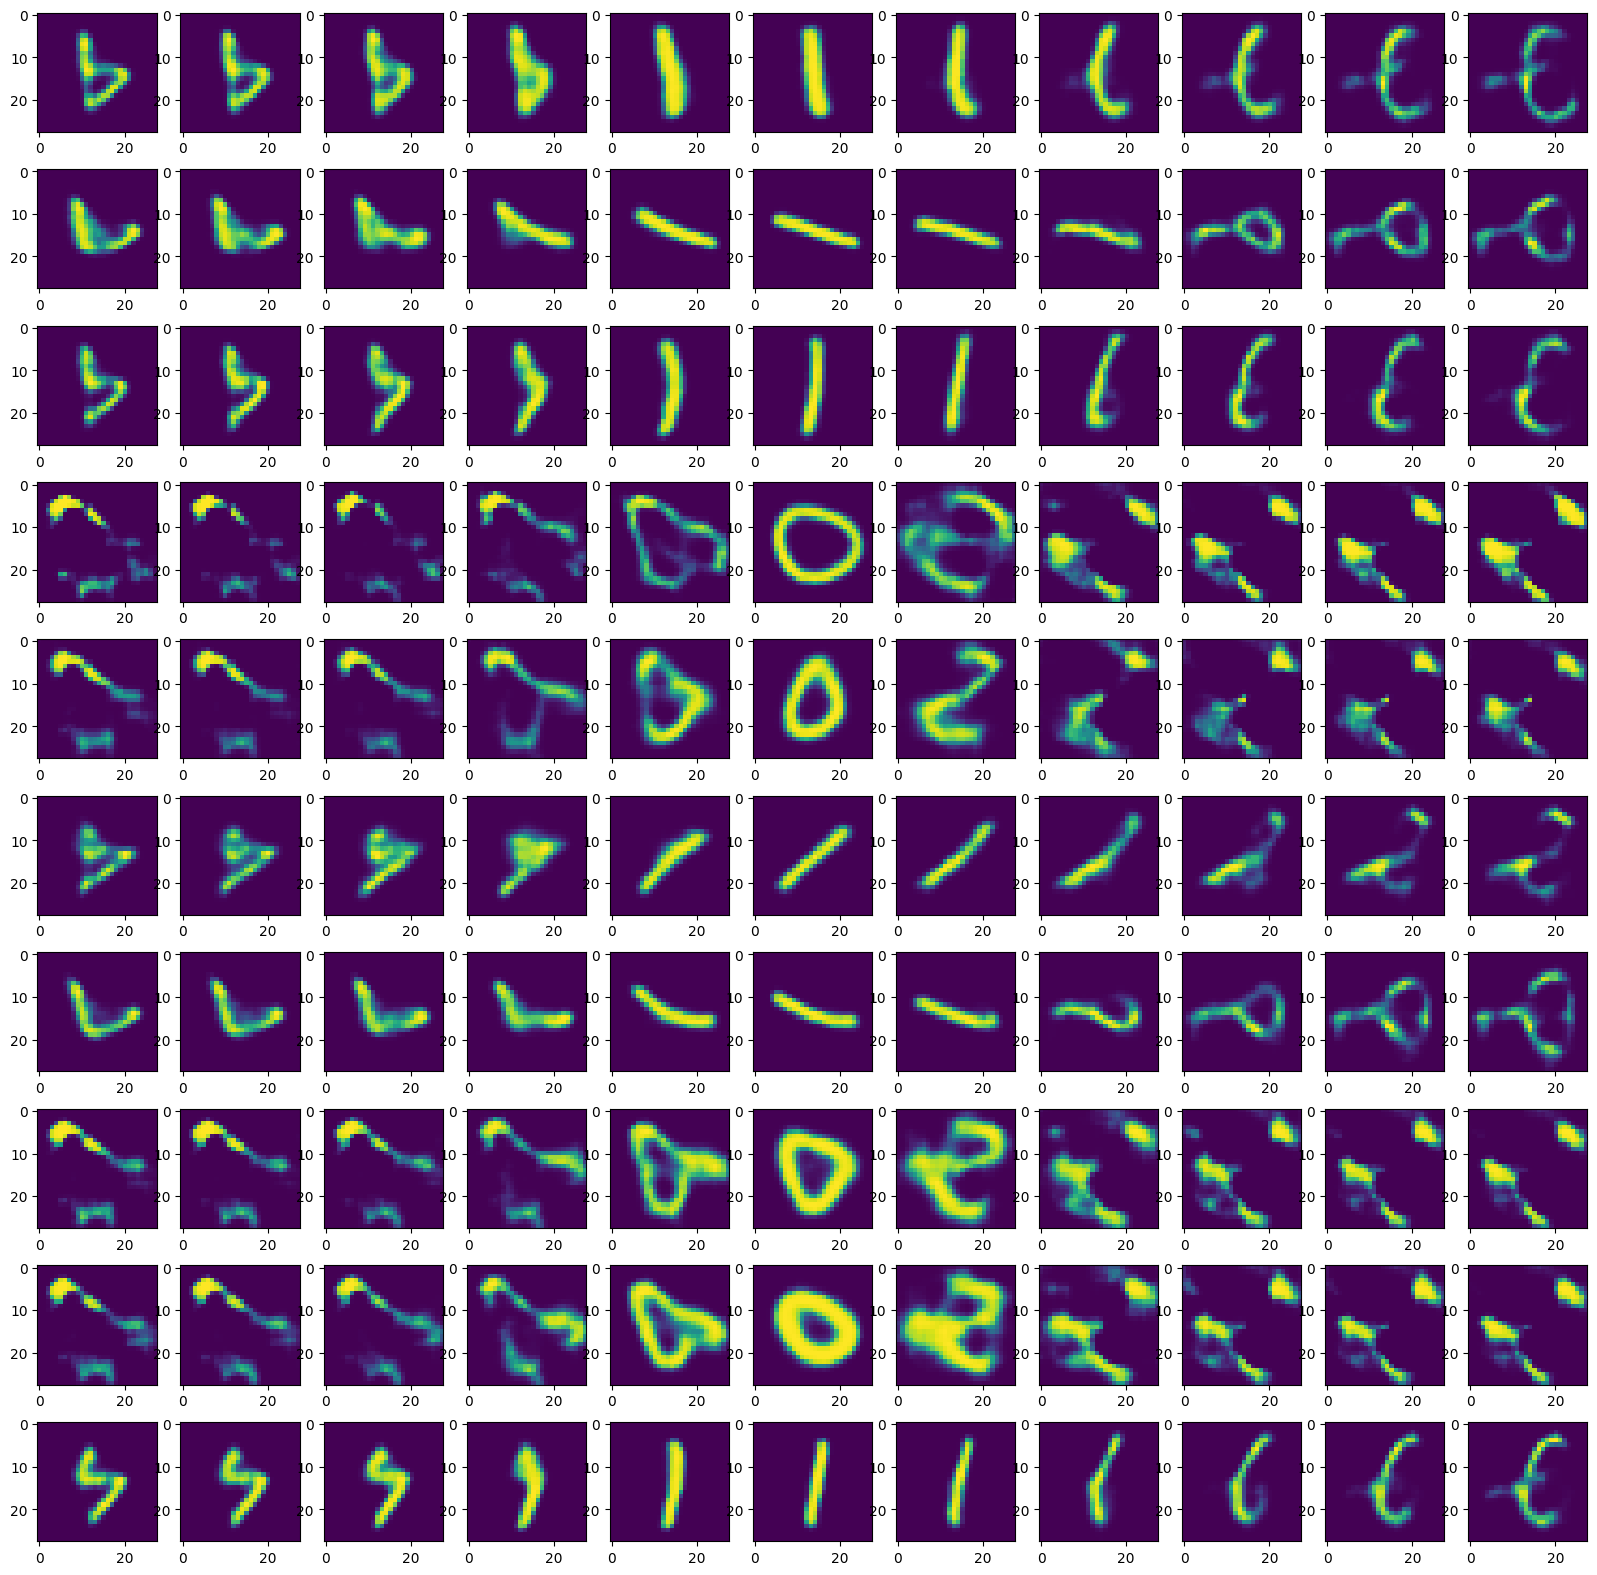

In [24]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step),],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

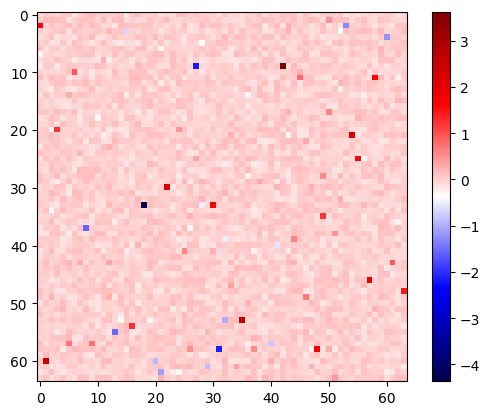

In [13]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

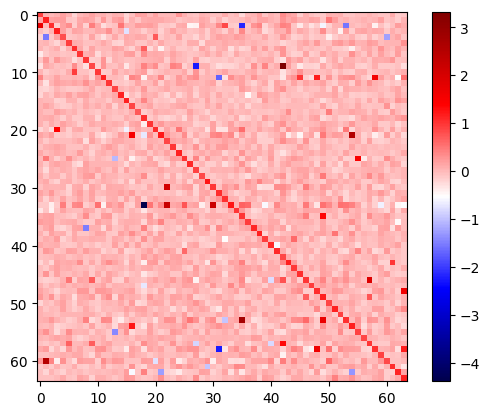

In [14]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

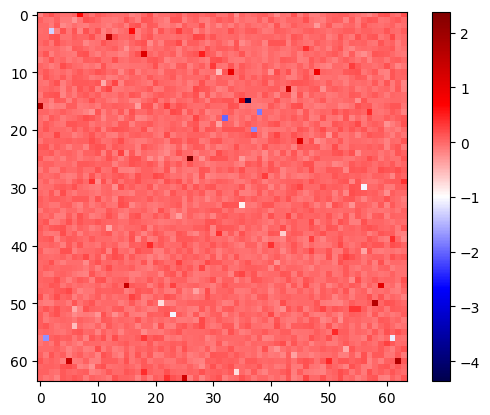

In [15]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

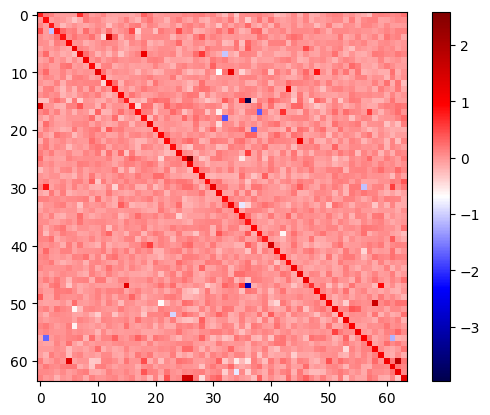

In [16]:
plt.imshow(torch.matrix_exp(model_symmetry.group[1].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

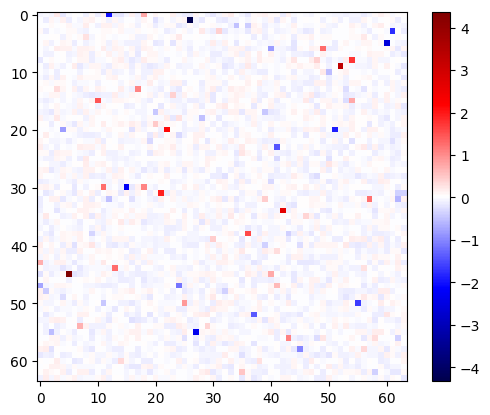

In [17]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

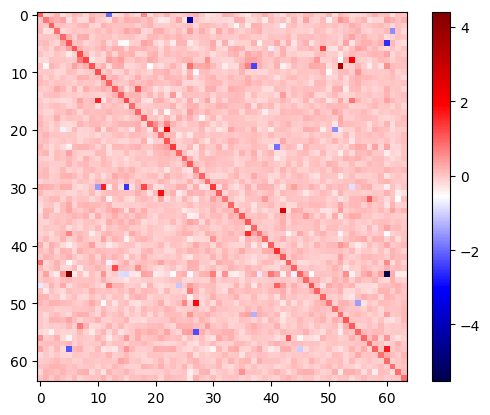

In [18]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()